# MADEモデルの予測テスト

MADEモデルの予測部分のコードおよび、それに伴うモデルの構造変更(出力層のsigmoid活性化関数の削除)のテスト

## import

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch

import made
import ising_model as ising
from ising_model import Ising_model
import QAOA_function as qaoa
from QAOA_function import QAOA_ansatz

plt.rcParams["font.family"] = "Helvetica Neue"
plt.rcParams['mathtext.fontset'] = 'cm'

seed = 1514
rng = np.random.default_rng(seed)

## 0. テスト用データ

二項分布。

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


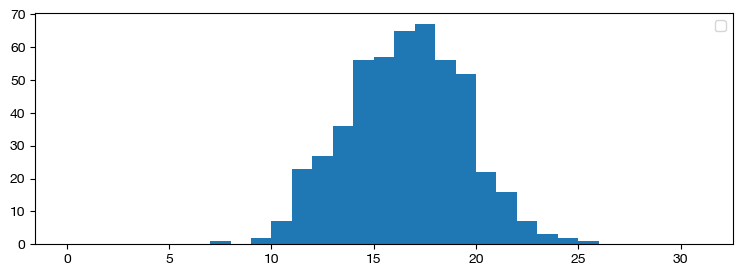

In [3]:
size = 32
p = 0.5
n_data = 500
data = np.random.binomial(size, p, n_data)

hist = np.histogram(data, bins=np.arange(size))

fig0, ax0 = plt.subplots(figsize=(9,3))
ax0.hist(data, bins=hist[1])
ax0.legend()

## 1. 学習テスト

In [4]:
data_nd = np.array([made.number_to_binary(data[i], 5) for i in range(data.shape[0])], dtype=np.float32)
data_th = torch.from_numpy(data_nd)
traindata, testdata = torch.utils.data.random_split(dataset=data_th, lengths=[400,100])
trainset = torch.utils.data.DataLoader(traindata, batch_size=8, shuffle=False)
testset = torch.utils.data.DataLoader(testdata, batch_size=8, shuffle=True)

hidden_layers = 2
hidden_size = 10
hidden_list = [hidden_size for i in range(hidden_layers)]
model = made.MADE(5, hidden_list, 5, num_masks=1, natural_ordering=True)
opt = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=45, gamma=0.1)

n_epochs = 30
train_loss, test_loss = made.run_train(model, trainset, testset, n_epochs, opt, scheduler)

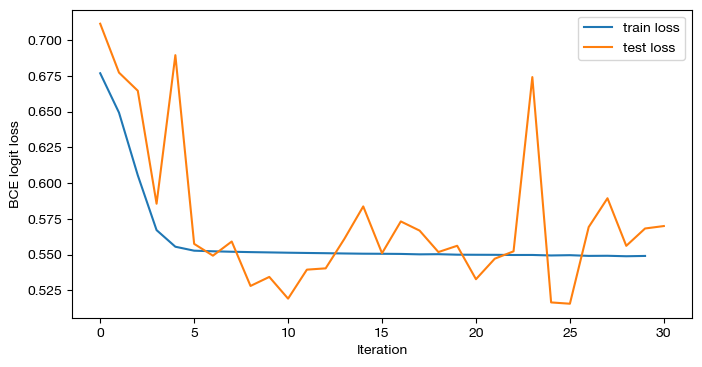

In [5]:
fig1, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(train_loss, label='train loss')
ax1.plot(test_loss, label='test loss')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('BCE logit loss')
ax1.legend()

## 2. 予測テスト

In [134]:
binary_list = made.number_to_binary(0, 5)
print(binary_list.astype(np.float32))
idx = made.binary_to_number(binary_list)
print(idx)
print(type(idx))

print(ising.number_to_spin(idx, 5))

[0. 0. 0. 0. 0.]
0
<class 'numpy.int64'>
[1 1 1 1 1]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


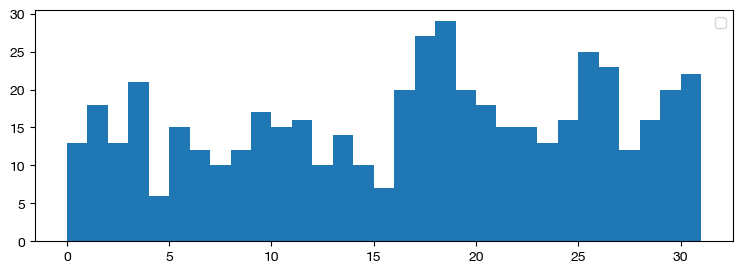

In [7]:
pred_data_nd = made.predict(model, data_nd)
pred_data = np.array([made.binary_to_number(pred_data_nd[i]) for i in range(pred_data_nd.shape[0])])

fig2_1, ax2_1 = plt.subplots(figsize=(9,3))
ax2_1.hist(pred_data, bins=hist[1])
ax2_1.legend()

sampling_MADE():
 [4.81734429e-06 6.34344953e-07 2.03969180e-06 3.06029733e-05
 4.03581582e-06 5.21434290e-05 2.00450672e-04 2.72208337e-03
 7.56268372e-03 5.76272359e-02 5.42695037e-02 6.83951635e-02
 4.51290609e-02 4.78032181e-02 4.60615712e-02 5.30135568e-02
 7.42797651e-02 7.82533532e-02 7.53731803e-02 8.66100811e-02
 6.17749366e-02 6.05982706e-02 6.24860282e-02 6.44288997e-02
 4.71176671e-02 4.12811116e-03 1.31600696e-03 1.04827722e-04
 3.45999659e-04 5.99961266e-05 1.66618125e-04 7.74569858e-05]
compute_log_prob():
 [4.81998541e-06 6.37482856e-07 2.03596665e-06 3.05979665e-05
 4.03564900e-06 5.21388647e-05 2.00448412e-04 2.72208848e-03
 7.56268390e-03 5.76272495e-02 5.42695150e-02 6.83951452e-02
 4.51290570e-02 4.78032306e-02 4.60615642e-02 5.30135520e-02
 7.42797852e-02 7.82533661e-02 7.53731951e-02 8.66100788e-02
 6.17749467e-02 6.05982840e-02 6.24860376e-02 6.44288883e-02
 4.71176617e-02 4.12811292e-03 1.31600723e-03 1.04827675e-04
 3.45999812e-04 5.99961859e-05 1.66618091e-04

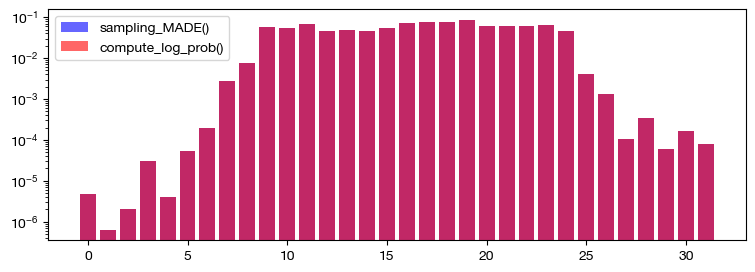

In [12]:
# old func
prob_1 = made.sampling_MADE(model)

# new func
all_inputs = np.array([made.number_to_binary(i, 5) for i in range(size)])
prob_2 = made.compute_log_prob(model, all_inputs)
prob_2 = np.exp(prob_2)

fig2_2, ax2_2 = plt.subplots(figsize=(9,3))
ax2_2.bar(np.arange(size), prob_1, color='blue', alpha=0.6, label='sampling_MADE()')
ax2_2.bar(np.arange(size), prob_2, color='red', alpha=0.6, label='compute_log_prob()')
ax2_2.set_yscale('log')
ax2_2.legend()

print("sampling_MADE():\n", prob_1)
print("compute_log_prob():\n", prob_2)

## 3. 追加実験: QAOAサンプル

本当に学習できているのか不安なのでQAOAでも試す。

### インスタンス定義・QAOA実行

In [2]:
n_spin = 10
instance = Ising_model(n_spin, rng, type='SK')

# setting
prob_hamiltonian = instance.get_hamiltonian()
mixer_hamiltonian = qaoa.generate_X_mixer(n_spin)
n_layers = 5
qaoa_ansatz = QAOA_ansatz(prob_hamiltonian, mixer_hamiltonian, n_layers)

def cost(para):
    return qaoa.cost_QAOA(prob_hamiltonian, qaoa_ansatz, para)

def callback(para):
    para_history.append(para)
    cost_history.append(cost(para))

# running QAOA
#init_para = [rng.uniform(0, 2*np.pi) for i in range(2*n_layers)]
init_para = [0.2705, -0.5899, 0.4803, -0.4492, 0.5074, -0.3559, 0.5646, -0.2643, 0.6397, -0.1291] #文献におけるSKmodelに対するQAOA(p=5)の固定角
para_history = [init_para]
cost_history = [cost(init_para)]

method = "BFGS"
options = {"disp": True, "maxiter": 200, "gtol": 1e-6}
opt = scipy.optimize.minimize(cost, init_para, 
                              method=method,
                              callback=callback,
                              options=options)

opt_para = para_history[-1]

# sampling QAOA outputs
n_samples = 2**10
opt_qaoa_data_idx = qaoa.sampling_QAOA(qaoa_ansatz, para_history[-1], n_samples) # optimize parameter
opt_qaoa_data_nd = np.array([qaoa.number_to_binary(opt_qaoa_data_idx[i], n_spin) for i in range(len(opt_qaoa_data_idx))], dtype='float32') # MADEモデルのコードが重み行列をfloat32で記述しているため、データもfloat32に明示的に指定する！

Optimization terminated successfully.
         Current function value: -4.138371
         Iterations: 24
         Function evaluations: 319
         Gradient evaluations: 29


### 訓練

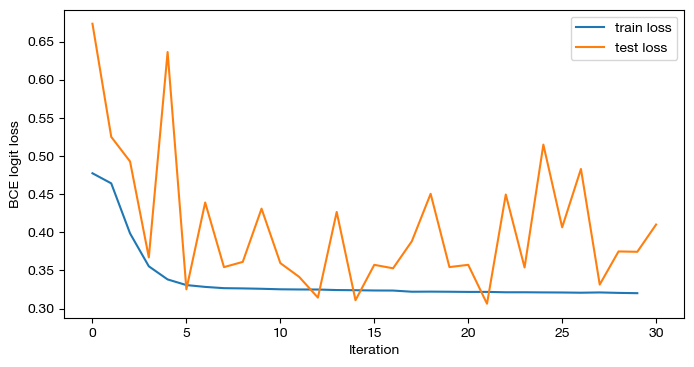

In [4]:
n_test = int(0.8*n_samples)

traindata, testdata = torch.utils.data.random_split(dataset=opt_qaoa_data_nd, lengths=[n_test, n_samples-n_test])
trainset = torch.utils.data.DataLoader(traindata, batch_size=8, shuffle=False)
testset = torch.utils.data.DataLoader(testdata, batch_size=8, shuffle=True)

hidden_layers = 2
hidden_size = 2*n_spin
hidden_list = [hidden_size for i in range(hidden_layers)]
model = made.MADE(n_spin, hidden_list, n_spin, num_masks=1, natural_ordering=True)
opt = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=45, gamma=0.1)

n_epochs = 30
train_loss, test_loss = made.run_train(model, trainset, testset, n_epochs, opt, scheduler, seed)

fig3_1, ax3_1 = plt.subplots(figsize=(8,4))
ax3_1.plot(train_loss, label='train loss')
ax3_1.plot(test_loss, label='test loss')
ax3_1.set_xlabel('Iteration')
ax3_1.set_ylabel('BCE logit loss')
ax3_1.legend()

### 分布

0.99999976


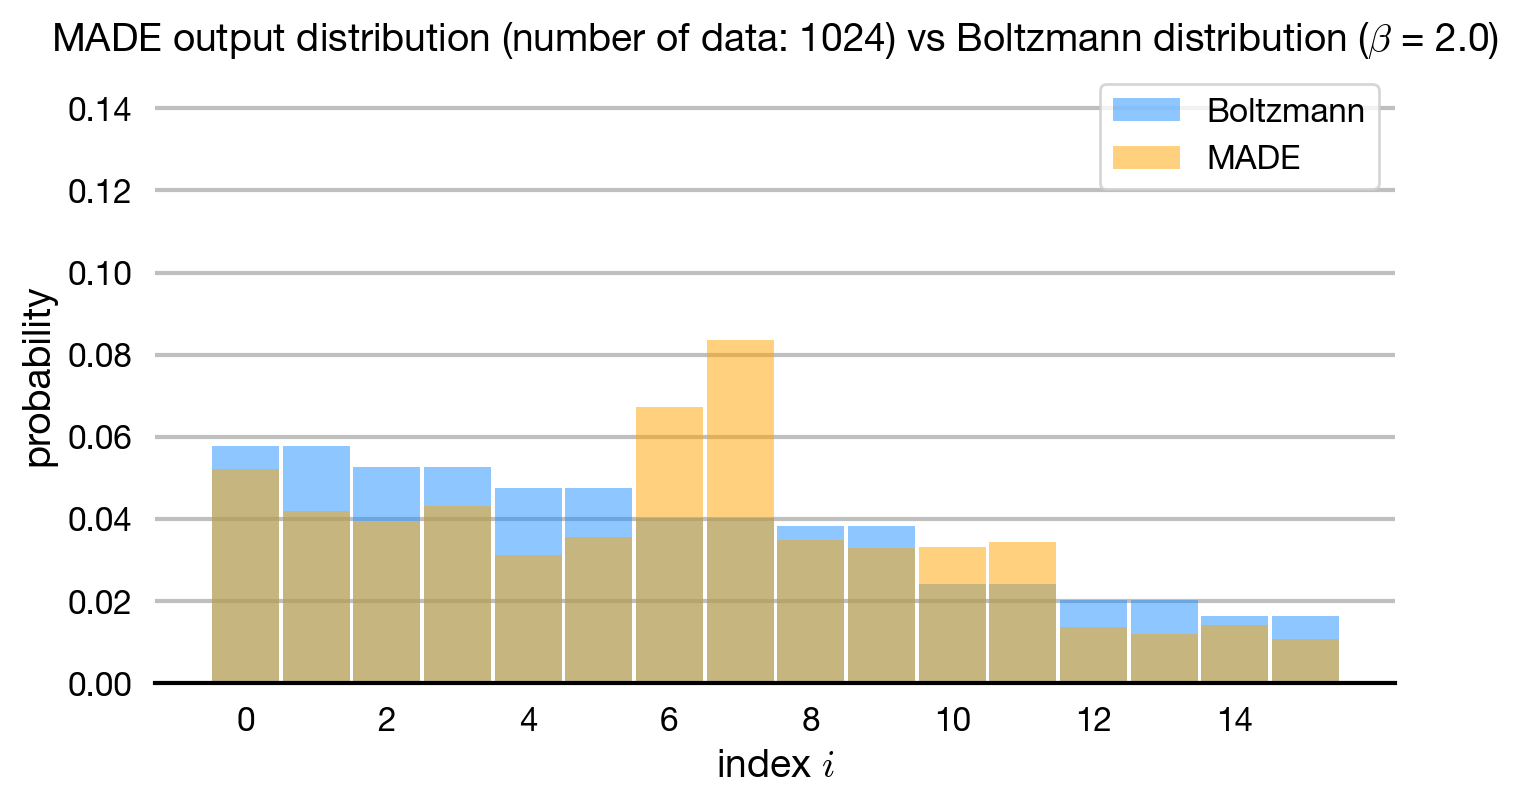

In [5]:
all_inputs = np.array([made.number_to_binary(i, n_spin) for i in range(2**n_spin)])
pred_prob = made.compute_log_prob(model, all_inputs)
pred_prob = np.exp(pred_prob)
print(np.sum(pred_prob))

# calculation
beta = 2.0
min_energy = ising.min_exact_spin_energy(instance)
boltzmann_prob = ising.spin_boltzmann_distribution(instance, beta)
boltzmann_prob_sort = np.sort(boltzmann_prob)[::-1]

# plot
n_top = 16
sort_idx = np.argsort(boltzmann_prob)[::-1]

fig3_2, ax3_2 = plt.subplots(figsize=(8,4), dpi=200)

ax3_2.spines["top"].set_linewidth(0)
ax3_2.spines["left"].set_linewidth(0)
ax3_2.spines["bottom"].set_linewidth(1.5)
ax3_2.spines["right"].set_linewidth(0)

ax3_2.bar(np.arange(n_top), boltzmann_prob_sort[0:n_top], width=0.95, color='dodgerblue', alpha=0.5, label="Boltzmann")
ax3_2.bar(np.arange(n_top), pred_prob[sort_idx[0:n_top]], width=0.95, color='orange', alpha=0.5, label="MADE")
ax3_2.grid(axis='y', color='#BFBFBF', linestyle='-', linewidth=1.5)
ax3_2.set_axisbelow(True) #gridを背面にする
ax3_2.set_xlabel(r'index $i$', fontsize=14)
ax3_2.set_ylabel("probability", fontsize=14)
ax3_2.set_xticks(np.arange(0, n_top, 2))
#ax3_2.set_yscale('log')
#ax3_2.set_ylim(1e-4, 1.1e0)
ax3_2.set_ylim(0, 0.15)
ax3_2.tick_params(width=0, labelsize=12, length=5)
ax3_2.tick_params(axis="y", which='minor', width=0.0)
ax3_2.set_title(r'MADE output distribution (number of data: {1}) vs Boltzmann distribution ($\beta$ = {0})'.format(beta, n_samples), fontsize=14)
ax3_2.legend(fontsize=12)

### 予測

In [6]:
opt_qaoa_data_idx_2 = qaoa.sampling_QAOA(qaoa_ansatz, para_history[-1], 100*n_samples) # optimize parameter
opt_qaoa_data_nd_2 = np.array([qaoa.number_to_binary(opt_qaoa_data_idx_2[i], n_spin) for i in range(len(opt_qaoa_data_idx_2))], dtype='float32')

qaoa_pred_data_nd = made.predict(model, opt_qaoa_data_nd_2)
qaoa_pred_data_id = np.array([made.binary_to_number(qaoa_pred_data_nd[i]) for i in range(qaoa_pred_data_nd.shape[0])])
qaoa_hist = np.histogram(qaoa_pred_data_id, bins=np.arange(2**n_spin))

fig3_3, ax3_3 = plt.subplots(figsize=(8,4), dpi=200)
ax3_3.bar(np.arange(n_top), qaoa_hist[0][sort_idx[0:n_top]])
ax3_3.legend()

RuntimeError: Expected p_in >= 0 && p_in <= 1 to be true, but got false.  (Could this error message be improved?  If so, please report an enhancement request to PyTorch.)

In [105]:
def predict_2(model, inputs):
	n = model.nin
    
	# convert ndarray to torch.tensor
	inputs_th = torch.from_numpy(inputs).to(dtype=torch.float32)

	# apply model and sampling
	logits = model(inputs_th)
	pred_th = torch.sigmoid(logits)
	pred_dist = pred_th.detach().numpy()

	outputs = np.zeros((inputs.shape[0],n))
	for i in range(outputs.shape[0]):
		for j in range(n):
			if pred_dist[i,j] >= rng.uniform(0.0, 1.0):
				outputs[i,j] = 1
			else:
				outputs[i,j] = 0
    
	return outputs

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


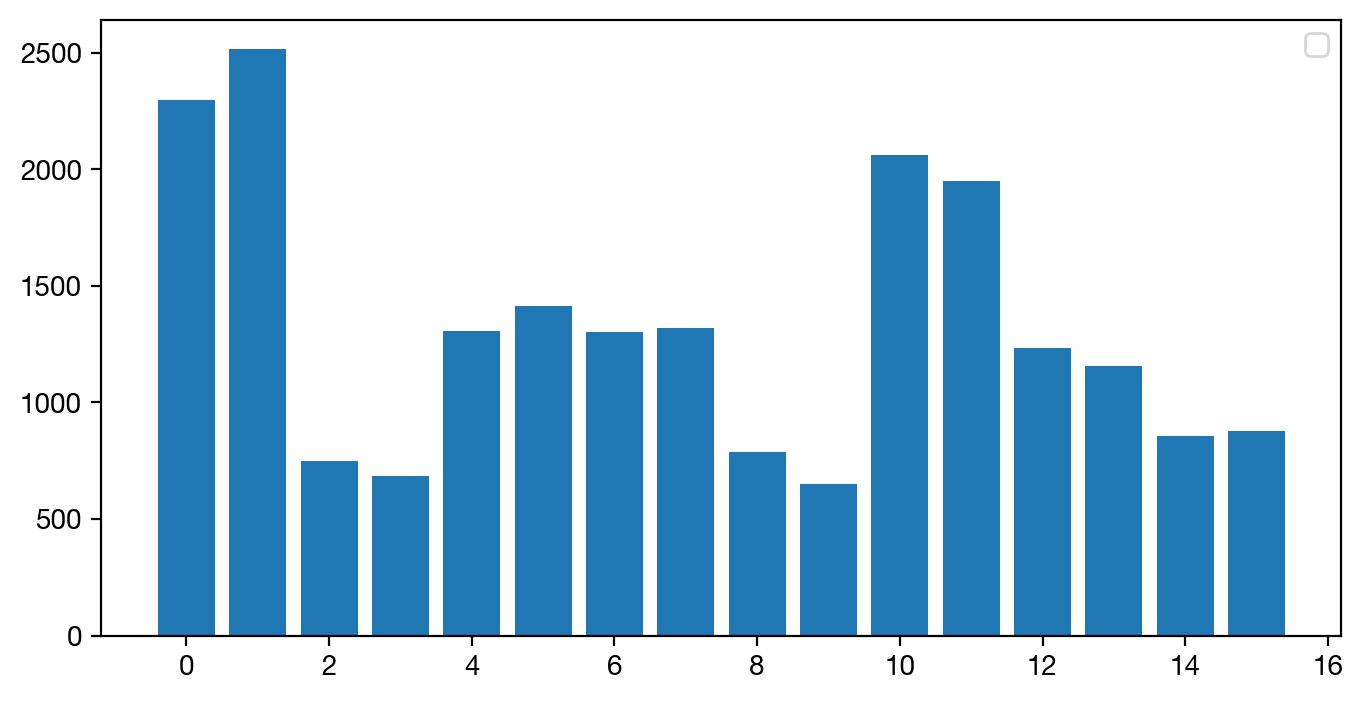

In [106]:
qaoa_pred_data_nd_2 = predict_2(model, opt_qaoa_data_nd_2)
qaoa_pred_data_id_2 = np.array([made.binary_to_number(qaoa_pred_data_nd_2[i]) for i in range(qaoa_pred_data_nd_2.shape[0])])
qaoa_hist_2 = np.histogram(qaoa_pred_data_id_2, bins=np.arange(2**n_spin))

fig3_4, ax3_4 = plt.subplots(figsize=(8,4), dpi=200)
ax3_4.bar(np.arange(n_top), qaoa_hist_2[0][sort_idx[0:n_top]])
ax3_4.legend()

In [126]:
inputs = made.number_to_binary(sort_idx[3], 10).copy()
print(made.compute_log_prob(model, inputs))

-2.9553514
